# Fraud Detection Using XGBoost - Credit Card Dataset
This notebook demonstrates how to detect fraudulent credit card transactions using the XGBoost classifier.
It includes data preprocessing, handling class imbalance, model training, evaluation, and interpretation.

## 1. Import Libraries
Essential Python libraries for data handling (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), machine learning (`scikit-learn`, `imbalanced-learn`, `xgboost`), and interpretability (`shap`).

In [1]:
!pip install -q imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Load and Inspect Dataset
The credit card transactions dataset is loaded from Google Drive. Its structure (rows, columns, head) and the class distribution (fraud/not fraud) are displayed. The dataset is highly imbalanced (very few frauds).

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/creditcard.csv')

print("Dataset shape:", df.shape)
print(df.head())

print("\nClass distribution:")
print(df['Class'].value_counts(normalize=True))

Dataset shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

## 3. Data Preprocessing
### 3.1 Feature Scaling

In [ ]:
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

### 3.2 Separate Features and Target

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

## 4. Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 5. Handle Class Imbalance Using SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

Before SMOTE: Class
0    199020
1       344
Name: count, dtype: int64
After SMOTE: Class
0    199020
1    199020
Name: count, dtype: int64


## 6. Train XGBoost Classifier with Hyperparameter Tuning

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:42:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


## 7. Model Evaluation

Confusion Matrix:


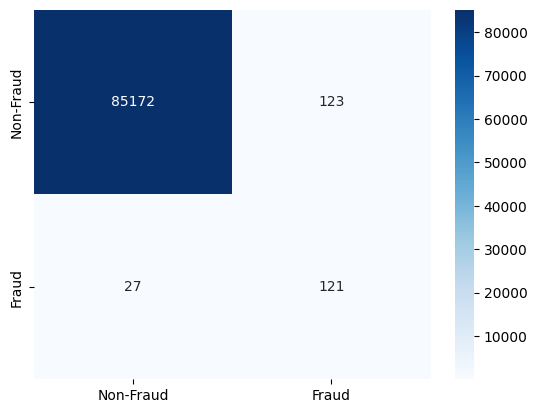


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.50      0.82      0.62       148

    accuracy                           1.00     85443
   macro avg       0.75      0.91      0.81     85443
weighted avg       1.00      1.00      1.00     85443

ROC AUC Score: 0.9754
Precision-Recall AUC: 0.8085


In [ ]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

## 8. Model Interpretability with SHAP

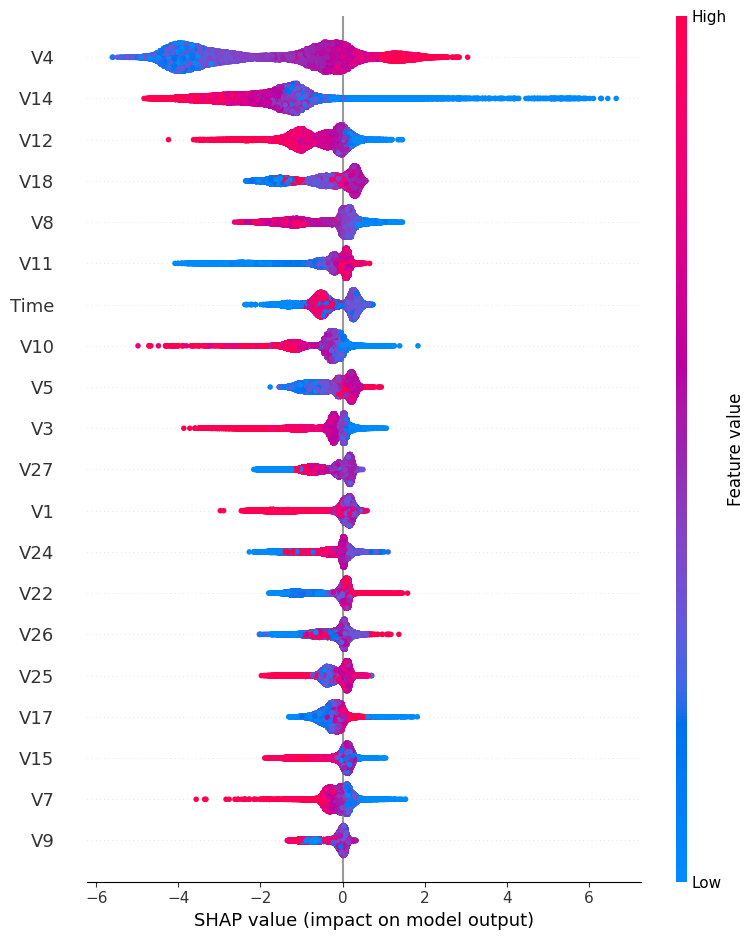

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

## 9. Predict on Full Dataset and Flag Fraudulent Transactions

In [ ]:
df['Fraud_Probability'] = best_model.predict_proba(X)[:, 1]
df['Fraud_Predicted'] = (df['Fraud_Probability'] > 0.5).astype(int)

print(f"Total flagged frauds: {df['Fraud_Predicted'].sum()}")

Total flagged frauds: 749


## Conclusion
This notebook demonstrates a strong baseline for credit card fraud detection using XGBoost, balancing the data with SMOTE, tuning hyperparameters, and interpreting model predictions with SHAP.

